In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0281

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - loss: 0.0202
Average validation loss: 0.699020266532898
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - loss: 0.0202 - val_loss: 0.6990
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - loss: 0.0134 - val_loss: 0.6990
Average validation loss: 0.6435167193412781
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - loss: 0.0134 - val_loss: 0.6713
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 561ms/step - loss: 0.0095 - val_loss: 0.6713
Average validation loss: 0.5784213542938232
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 573ms/step - loss: 0.0095 - val_loss: 0.6403
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segfor

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 763ms/step - loss: 9.4567e-06
Average validation loss: 0.19613538309931755
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 776ms/step - loss: 9.4567e-06 - val_loss: 0.1961
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 777ms/step - loss: 9.1172e-06 - val_loss: 0.1961
Average validation loss: 0.15913314372301102
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 786ms/step - loss: 9.1172e-06 - val_loss: 0.1776
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 801ms/step - loss: 8.8676e-06 - val_loss: 0.1776
Average validation loss: 0.1877293847501278
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 815ms/step - loss: 8.8676e-06 - val_loss: 0.1810
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 798ms/step - loss: 8.7591e-06 - val_loss: 0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 814ms/step - loss: 1.9158e-06
Average validation loss: 0.14067785441875458
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 824ms/step - loss: 1.9158e-06 - val_loss: 0.1407
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 786ms/step - loss: 2.5088e-06 - val_loss: 0.1407
Average validation loss: 0.09793746347228686
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 795ms/step - loss: 2.5088e-06 - val_loss: 0.1193
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 827ms/step - loss: 2.3333e-06 - val_loss: 0.1193
Average validation loss: 0.05936510985096296
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 836ms/step - loss: 2.3333e-06 - val_loss: 0.0993
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\wei

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - loss: 2.9711e-07
Average validation loss: 0.027843025280162692
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 832ms/step - loss: 2.9711e-07 - val_loss: 0.0278
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 838ms/step - loss: 2.9030e-07 - val_loss: 0.0278
Average validation loss: 0.022373769315890968
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 849ms/step - loss: 2.9030e-07 - val_loss: 0.0251
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 783ms/step - loss: 2.5008e-07 - val_loss: 0.0251
Average validation loss: 0.02936315955594182
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 794ms/step - loss: 2.5008e-07 - val_loss: 0.0265
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 794ms/step - loss: 2.600

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 783ms/step - loss: 4.0540e-07
Average validation loss: 0.029104361683130263
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 794ms/step - loss: 4.0540e-07 - val_loss: 0.0291
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 814ms/step - loss: 3.4545e-07 - val_loss: 0.0291
Average validation loss: 0.0941469632089138
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 826ms/step - loss: 3.4545e-07 - val_loss: 0.0616
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 768ms/step - loss: 3.0508e-07 - val_loss: 0.0616
Average validation loss: 0.03114105500280857
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 781ms/step - loss: 3.0508e-07 - val_loss: 0.0515
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 772ms/step - loss: 2.7257e-07 - val_loss: 0.0515
Average validation loss: 0.037782732769846915
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 783ms/step - loss: 2.7257e-07 - val_loss: 0.0480
Epoch 5/

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 762ms/step - loss: 8.4300e-07
Average validation loss: 0.029615094574789207
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 773ms/step - loss: 8.4300e-07 - val_loss: 0.0296
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 824ms/step - loss: 7.4129e-07 - val_loss: 0.0296
Average validation loss: 0.017520348619048793
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 837ms/step - loss: 7.4129e-07 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 769ms/step - loss: 5.8421e-07 - val_loss: 0.0236
Average validation loss: 0.013608823142324885
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 783ms/step - loss: 5.8421e-07 - val_loss: 0.0202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 754ms/step - loss: 4.8666e-07
Average validation loss: 0.030426803848240525
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 765ms/step - loss: 4.8666e-07 - val_loss: 0.0304
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 801ms/step - loss: 3.7819e-07 - val_loss: 0.0304
Average validation loss: 0.02708525222260505
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 811ms/step - loss: 3.7819e-07 - val_loss: 0.0288
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 779ms/step - loss: 3.3292e-07 - val_loss: 0.0288
Average validation loss: 0.02229182191658765
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 789ms/step - loss: 3.3292e-07 - val_loss: 0.0266
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 777ms/step - loss: 2.2958e-07
Average validation loss: 0.053848773784314595
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 2.2958e-07 - val_loss: 0.0538
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 819ms/step - loss: 4.2509e-07 - val_loss: 0.0538
Average validation loss: 0.06640057642168055
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 831ms/step - loss: 4.2509e-07 - val_loss: 0.0601
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 788ms/step - loss: 3.5523e-07 - val_loss: 0.0601
Average validation loss: 0.03341390104227079
48/48 ━━━━━━━━━━━━━━━━━━━━ 116s 800ms/step - loss: 3.5523e-07 - val_loss: 0.0512
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 153s 779ms/step - loss: 3.0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 785ms/step - loss: 1.0138e-07
Average validation loss: 0.015233594392027174
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 797ms/step - loss: 1.0138e-07 - val_loss: 0.0152
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 925ms/step - loss: 8.0405e-08 - val_loss: 0.0152
Average validation loss: 0.01964132733909147
56/56 ━━━━━━━━━━━━━━━━━━━━ 97s 937ms/step - loss: 8.0405e-08 - val_loss: 0.0174
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 904ms/step - loss: 6.6441e-08 - val_loss: 0.0174
Average validation loss: 0.02467548248491117
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 915ms/step - loss: 6.6441e-08 - val_loss: 0.0199
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 192s 789ms/step - loss: 5.8245e-08 - val_loss: 0.0199
Average validation loss: 0.021065746700125083
56/56 ━━━━━━━━━━━━━━━━━━━━ 193s 801ms/step - loss: 5.8245e-08 - val_loss: 0.0202
Epo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - loss: 6.5474e-08
Average validation loss: 0.017869622737634927
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 862ms/step - loss: 6.5474e-08 - val_loss: 0.0179
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 779ms/step - loss: 7.3908e-08 - val_loss: 0.0179
Average validation loss: 0.030847576854284853
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 790ms/step - loss: 7.3908e-08 - val_loss: 0.0244
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 783ms/step - loss: 6.1187e-08 - val_loss: 0.0244
Average validation loss: 0.013282323925523087
64/64 ━━━━━━━━━━━━━━━━━━━━ 157s 794ms/step - loss: 6.1187e-08 - val_loss: 0.0207
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 800ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 785ms/step - loss: 5.1578e-08
Average validation loss: 0.02831387086512728
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 796ms/step - loss: 5.1578e-08 - val_loss: 0.0283
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 791ms/step - loss: 4.9788e-08 - val_loss: 0.0283
Average validation loss: 0.015997928677178506
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 802ms/step - loss: 4.9788e-08 - val_loss: 0.0222
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 786ms/step - loss: 4.4980e-08 - val_loss: 0.0222
Average validation loss: 0.01528268449086075
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 797ms/step - loss: 4.4980e-08 - val_loss: 0.0199
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0D

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 775ms/step - loss: 2.0651e-07
Average validation loss: 0.023572493926621974
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - loss: 2.0651e-07 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 803ms/step - loss: 2.5015e-07 - val_loss: 0.0236
Average validation loss: 0.04816281972452998
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 814ms/step - loss: 2.5015e-07 - val_loss: 0.0359
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 193s 813ms/step - loss: 3.9898e-07 - val_loss: 0.0359
Average validation loss: 0.024242480361135677
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 824ms/step - loss: 3.9898e-07 - val_loss: 0.0320
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 258s 794ms/step - loss: 3.2692e-07 - val_loss: 0.0320
Average validation loss: 0.01951666227541864
80/80 ━━━━━━━━━━━━━━━━━━━━ 259s 805ms/step - loss: 3.2692e-07 - val_loss: 0.0289


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 813ms/step - loss: 1.0981e-07
Average validation loss: 0.022852224259016413
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 823ms/step - loss: 1.0981e-07 - val_loss: 0.0229
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 775ms/step - loss: 9.3110e-08 - val_loss: 0.0229
Average validation loss: 0.020274620270356536
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 786ms/step - loss: 9.3110e-08 - val_loss: 0.0216
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 229s 776ms/step - loss: 7.6550e-08 - val_loss: 0.0216
Average validation loss: 0.021505281911231577
96/96 ━━━━━━━━━━━━━━━━━━━━ 230s 786ms/step - loss: 7.6550e-08 - val_loss: 0.0215
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 305s 783ms/step - los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 780ms/step - loss: 5.3940e-07
Average validation loss: 0.017918284237384795
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 791ms/step - loss: 5.3940e-07 - val_loss: 0.0179
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 800ms/step - loss: 3.5574e-07 - val_loss: 0.0179
Average validation loss: 0.02184529062360525
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 811ms/step - loss: 3.5574e-07 - val_loss: 0.0199
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 814ms/step - loss: 2.9637e-07 - val_loss: 0.0199
Average validation loss: 0.020624668422775962
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 825ms/step - loss: 2.9637e-07 - val_loss: 0.0201
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 388s 806ms/step - loss: 2.5145e-07 - val_loss: 0.0201
Average validation loss: 0.024437073587129512
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 818ms/step - loss: 2.5145e-07 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/step - loss: 2.0930e-07
Average validation loss: 0.02435423177666962
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 800ms/step - loss: 2.0930e-07 - val_loss: 0.0244
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 803ms/step - loss: 1.5859e-07 - val_loss: 0.0244
Average validation loss: 0.021588645280442305
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 814ms/step - loss: 1.5859e-07 - val_loss: 0.0230
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 346s 789ms/step - loss: 1.3067e-07 - val_loss: 0.0230
Average validation loss: 0.020671894553945296
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 800ms/step - loss: 1.3067e-07 - val_loss: 0.0222
Saved model weights to 'c:\天_11157065\git\Ripp

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 805ms/step - loss: 7.5143e-08
Average validation loss: 0.01820905297063291
160/160 ━━━━━━━━━━━━━━━━━━━━ 131s 816ms/step - loss: 7.5143e-08 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 260s 809ms/step - loss: 5.3139e-08 - val_loss: 0.0182
Average validation loss: 0.015830182854551823
160/160 ━━━━━━━━━━━━━━━━━━━━ 262s 819ms/step - loss: 5.3139e-08 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 792ms/step - loss: 4.4822e-08 - val_loss: 0.0170
Average validation loss: 0.01586266653612256
160/160 ━━━━━━━━━━━━━━━━━━━━ 390s 803ms/step - loss: 4.4822e-08 - val_loss: 0.0166
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 517s 79

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 793ms/step - loss: 7.1276e-08
Average validation loss: 0.01907431853702292
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 804ms/step - loss: 7.1276e-08 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 318s 784ms/step - loss: 5.3268e-08 - val_loss: 0.0191
Average validation loss: 0.014567280126502737
200/200 ━━━━━━━━━━━━━━━━━━━━ 320s 795ms/step - loss: 5.3268e-08 - val_loss: 0.0168
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 482s 809ms/step - loss: 4.6229e-08 - val_loss: 0.0168
Average validation loss: 0.015662650565209334
200/200 ━━━━━━━━━━━━━━━━━━━━ 484s 820ms/step - loss: 4.6229e-08 - val_loss: 0.0164
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 644s 7

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 795ms/step - loss: 3.6336e-08
Average validation loss: 0.018503800376007955
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 807ms/step - loss: 3.6336e-08 - val_loss: 0.0185
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 385s 797ms/step - loss: 2.8645e-08 - val_loss: 0.0185
Average validation loss: 0.015777323436486766
240/240 ━━━━━━━━━━━━━━━━━━━━ 388s 808ms/step - loss: 2.8645e-08 - val_loss: 0.0171
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 578s 794ms/step - loss: 2.7173e-08 - val_loss: 0.0171
Average validation loss: 0.014656873982554922
240/240 ━━━━━━━━━━━━━━━━━━━━ 581s 806ms/step - loss: 2.7173e-08 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\Rip

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.2661559186130762, 0.12475347178056836, 0.07106886360794305, 0.030730356777785347, 0.027309500300325452, 0.02692620718075583, 0.03019562294986099, 0.02060731044679415, 0.015553159170917102, 0.014548437077464768, 0.01774744881840888, 0.016302609210018998, 0.014215684956579934, 0.01895535446536572, 0.017751959889735897, 0.01525171686800968, 0.015761581894199482, 0.0162350543595979]
std_val_losses =  [0.17420926945890036, 0.09086322268106548, 0.03830634577423282, 0.017858385749308512, 0.01587353585781039, 0.014427792062700869, 0.014919283412640608, 0.010934102098080472, 0.0056883932500617004, 0.005302465498733412, 0.00952100462127171, 0.005746669608100461, 0.004098875466276203, 0.005435522131558964, 0.0032139972670514, 0.0033232374348605206, 0.0025015568804782292, 0.0030645065263571305]


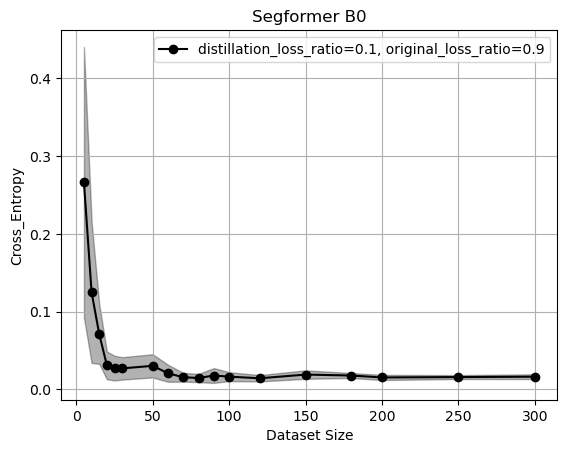

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()